In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-03-15 15:37:00.472346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 15:37:00.472496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 15:37:00.627757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
IMAGE_SIZE = 512
BATCH_SIZE = 20
CHANNELS = 3
EPOCHS = 10

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plastic-data-one/PLASTICS_DATA",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6801 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['HDPE', 'PET', 'PVC']

In [9]:
len(dataset)

341

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
#Rescaling images if user inputted img is not according to required format

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Layer, Flatten

In [16]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top = False,
                                                   input_shape = (512, 512, 3),
                                                   pooling = 'max', classes = 3,
                                                   weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(3, activation = 'softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
resnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
resnet_model.compile(
    optimizer = 'sgd',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [19]:
history = resnet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/10
  1/204 ━━━━━━━━━━━━━━━━━━━━ 2:45:01 49s/step - accuracy: 0.4500 - loss: 4.7164

I0000 00:00:1710517095.239291     192 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710517095.293665     192 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5822 - loss: 10.5062

W0000 00:00:1710517150.542309     193 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 115s 324ms/step - accuracy: 0.5826 - loss: 10.4696 - val_accuracy: 0.8665 - val_loss: 0.3355
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 76s 275ms/step - accuracy: 0.7962 - loss: 0.6602 - val_accuracy: 0.9530 - val_loss: 0.1435
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 76s 274ms/step - accuracy: 0.9454 - loss: 0.1627 - val_accuracy: 0.9669 - val_loss: 0.0943
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 76s 276ms/step - accuracy: 0.9664 - loss: 0.0976 - val_accuracy: 0.9743 - val_loss: 0.0589
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 77s 277ms/step - accuracy: 0.9705 - loss: 0.0881 - val_accuracy: 0.9838 - val_loss: 0.0517
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 77s 277ms/step - accuracy: 0.9753 - loss: 0.0745 - val_accuracy: 0.9794 - val_loss: 0.0605
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 76s 274ms/step - accuracy: 0.9790 - loss: 0.0613 - val_accuracy: 0.9821 - val_loss: 0.0482
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 77s 277ms/step - accuracy: 0.9788 - loss: 0.0599 - v

In [20]:
scores = resnet_model.evaluate(test_ds)
scores

69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.9876 - loss: 0.0268


[0.03026057966053486, 0.989130437374115]

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [24]:
import numpy as np

Testing with unknown output

In [165]:
unknown_img_path = "/kaggle/input/disposable-bags-classification-using-yolov5/yolov5/images/test/00001120.jpg"  
unknown_img = tf.keras.preprocessing.image.load_img(unknown_img_path, target_size=(512, 512))

predicted_class, confidence = predict(resnet_model, unknown_img)
print("Predicted Class:", predicted_class)
print("Confidence:", confidence, "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: HDPE
Confidence: 100.0 %


In [166]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  **LIME IMPLEMENTATION**

In [167]:
explainer = lime_image.LimeImageExplainer()

In [168]:
import skimage.io 
import skimage.segmentation

In [169]:
import numpy as np
from keras.applications.imagenet_utils import decode_predictions

In [170]:
unknown_img_array = tf.keras.preprocessing.image.img_to_array(unknown_img)

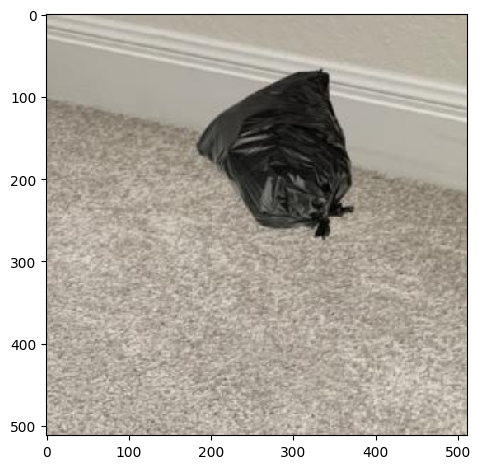

In [171]:
Xi = skimage.io.imread("/kaggle/input/disposable-bags-classification-using-yolov5/yolov5/images/test/00001120.jpg") 
Xi = skimage.transform.resize(Xi, (512,512,3)) 
skimage.io.imshow(Xi)
Xi = (Xi - 0.5)*2

In [172]:
Xi

array([[[0.5580576 , 0.52668505, 0.44041054],
        [0.56075368, 0.52938113, 0.44310662],
        [0.56994485, 0.5385723 , 0.45229779],
        ...,
        [0.41696885, 0.36206689, 0.23657669],
        [0.42251587, 0.36761391, 0.24212371],
        [0.42414299, 0.36924103, 0.24375084]],

       [[0.5270527 , 0.49568015, 0.40940564],
        [0.52974877, 0.49837623, 0.41210172],
        [0.53893995, 0.5075674 , 0.42129289],
        ...,
        [0.42106036, 0.3661584 , 0.2406682 ],
        [0.42739725, 0.37249528, 0.24700509],
        [0.42925607, 0.3743541 , 0.24886391]],

       [[0.42135417, 0.38998162, 0.30370711],
        [0.42405025, 0.3926777 , 0.30640319],
        [0.43324142, 0.40186887, 0.31559436],
        ...,
        [0.43500869, 0.38010673, 0.25461653],
        [0.4440383 , 0.38913634, 0.26364614],
        [0.44668699, 0.39178503, 0.26629483]],

       ...,

       [[0.48589274, 0.42314764, 0.33687313],
        [0.47730952, 0.41456442, 0.32828991],
        [0.44804855, 0

**The higher the kernel size,max_dist, the fewer are the clusters
Segments image using quickshift clustering**

In [173]:
superpixels = skimage.segmentation.quickshift(unknown_img_array, kernel_size=4,max_dist=200, ratio=0.2) #
num_superpixels = np.unique(superpixels).shape[0]
print("The number of super pixels generated")
num_superpixels

The number of super pixels generated


352

**The generated superpixels are shown in the image below using mark_boundaries.**

/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


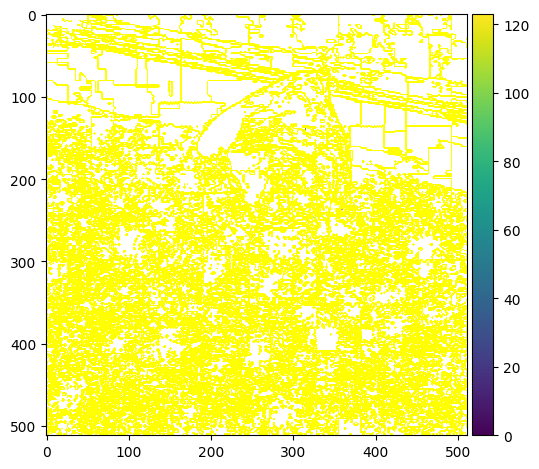

In [174]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(unknown_img_array/2+0.5, superpixels))

In [175]:
np.random.seed(222)
num_perturb = 150 
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels)) 
print(" Here, '1' represent ON(active) superpixel and '0' represents OFF.")
perturbations[0]

 Here, '1' represent ON(active) superpixel and '0' represents OFF.


array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,

In [176]:
import copy

In [177]:
def perturb_image(img,perturbation,segments): 
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

The perturbed image


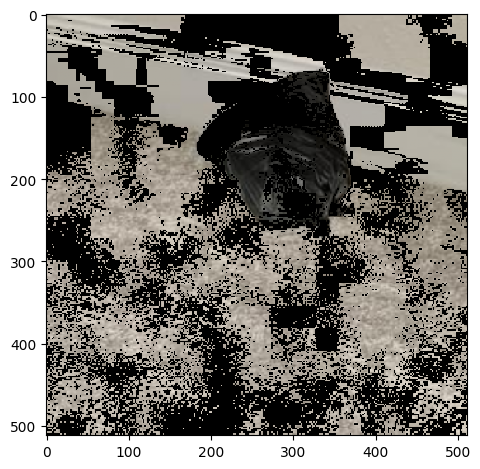

In [178]:
print("The perturbed image")
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels)) 

In [179]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    pred = resnet_model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [180]:
import sklearn.metrics

**Compute distances between the original image and each of the perturbed images.**

In [181]:
original_image = np.ones(num_superpixels)[np.newaxis,:]
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

In [182]:
distances

array([0.28291943, 0.30709767, 0.2989456 , 0.29490491, 0.34720879,
       0.3009747 , 0.27896854, 0.29490491, 0.26918476, 0.3009747 ,
       0.28888692, 0.28888692, 0.28689221, 0.2989456 , 0.29490491,
       0.28291943, 0.26918476, 0.28094127, 0.30505069, 0.2989456 ,
       0.25379749, 0.28291943, 0.30505069, 0.30300972, 0.28888692,
       0.2989456 , 0.28094127, 0.31120989, 0.27896854, 0.29490491,
       0.3407132 , 0.27308247, 0.29490491, 0.28094127, 0.31327523,
       0.27503919, 0.29490491, 0.26724368, 0.3493884 , 0.27700119,
       0.3009747 , 0.28490306, 0.28490306, 0.29088724, 0.26724368,
       0.30915072, 0.33428098, 0.29490491, 0.34503643, 0.30300972,
       0.2989456 , 0.30709767, 0.29088724, 0.27503919, 0.28094127,
       0.28888692, 0.2989456 , 0.27308247, 0.28689221, 0.28291943,
       0.27896854, 0.3153468 , 0.27700119, 0.31742466, 0.26337687,
       0.30915072, 0.28490306, 0.29490491, 0.28689221, 0.28689221,
       0.27700119, 0.29088724, 0.23129389, 0.27503919, 0.30505

**Compute weights (importance) of each perturbed image using kernel. The distances are then mapped to a value between zero and one (weight).**

In [183]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [184]:
weights

array([0.52710937, 0.47025892, 0.48921766, 0.49869967, 0.38119983,
       0.48447658, 0.53655426, 0.49869967, 0.5600756 , 0.48447658,
       0.51291497, 0.51291497, 0.5176494 , 0.48921766, 0.49869967,
       0.52710937, 0.5600756 , 0.53183394, 0.47499672, 0.48921766,
       0.59731818, 0.52710937, 0.47499672, 0.4797361 , 0.51291497,
       0.48921766, 0.53183394, 0.46079005, 0.53655426, 0.49869967,
       0.39507334, 0.55068501, 0.49869967, 0.53183394, 0.45605997,
       0.54598027, 0.49869967, 0.56476052, 0.3765976 , 0.54126987,
       0.48447658, 0.52238103, 0.52238103, 0.50817821, 0.56476052,
       0.4655232 , 0.40903679, 0.49869967, 0.38581352, 0.4797361 ,
       0.48921766, 0.47025892, 0.50817821, 0.54598027, 0.53183394,
       0.51291497, 0.48921766, 0.55068501, 0.5176494 , 0.52710937,
       0.53655426, 0.45133345, 0.54126987, 0.44661099, 0.57410728,
       0.4655232 , 0.52238103, 0.49869967, 0.5176494 , 0.5176494 ,
       0.54126987, 0.50817821, 0.65182778, 0.54598027, 0.47499

**Use 'perturbations', 'predictions' and 'weights' to fit an explainable (linear) model**

In [185]:
from sklearn.linear_model import LinearRegression

In [186]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [187]:
img_array = img_to_array(unknown_img)
img_array = np.expand_dims(img_array, axis=0)
img_array

array([[[[203., 199., 188.],
         [203., 199., 188.],
         [205., 201., 190.],
         ...,
         [180., 173., 157.],
         [181., 174., 158.],
         [181., 174., 158.]],

        [[203., 199., 188.],
         [203., 199., 188.],
         [205., 201., 190.],
         ...,
         [180., 173., 157.],
         [181., 174., 158.],
         [181., 174., 158.]],

        [[180., 176., 165.],
         [180., 176., 165.],
         [182., 178., 167.],
         ...,
         [183., 176., 160.],
         [185., 178., 162.],
         [185., 178., 162.]],

        ...,

        [[192., 184., 173.],
         [192., 184., 173.],
         [185., 177., 166.],
         ...,
         [198., 190., 177.],
         [197., 189., 176.],
         [197., 189., 176.]],

        [[157., 149., 138.],
         [157., 149., 138.],
         [168., 160., 149.],
         ...,
         [197., 189., 176.],
         [202., 194., 181.],
         [202., 194., 181.]],

        [[157., 149., 138.],
       

In [188]:
preds = resnet_model.predict(img_array)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([[9.9999833e-01, 1.6127128e-06, 5.2593201e-08]], dtype=float32)

In [189]:
preds.shape

(1, 3)

In [190]:
top_pred_classes = preds[0].argsort()[-3:][::-1]
print("The indices of the top classes ")
top_pred_classes 

The indices of the top classes 


array([0, 1, 2])

In [191]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,top_pred_classes[0]], sample_weight=weights) 
coeff = simpler_model.coef_[0] 
coeff.shape

(352,)

Compute top features (superpixels)

In [194]:
num_top_features = 50
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([233, 281, 137, 104,  32,  67, 350, 290, 130,   8, 334,  29, 341,
         5, 308, 222, 127, 349, 151, 237, 296, 223, 191,  28, 120, 315,
       163,  54, 183,   4, 272, 351,  56, 142,  30, 261,   2, 211, 103,
       140, 179, 241, 187, 276, 210,  24,  26,  78,  65, 177])

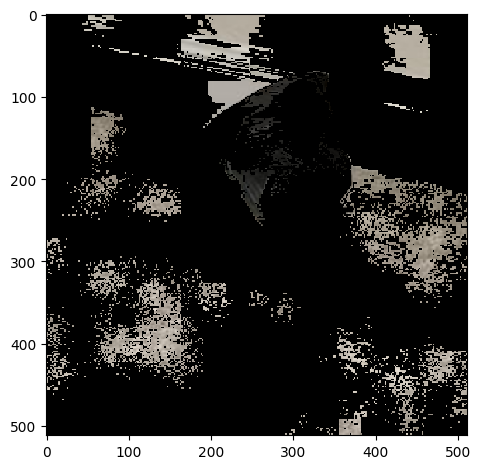

In [195]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True 
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )